In [1]:
import pdb
import time
import math
import random
import operator
import pandas as pd
from collections import Counter
import time


from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Data
 - Scenario 2: [Botnet-43](https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/)
 - Infected host: 147.32.84.165 

In [2]:
def getData(filename):    
    cols = ['Date','Duration','Protocol','Source','Destination','Label']
    list = []
    with open(filename) as file:  
        for count, line in enumerate(file):
            if count!=0:
                data = line.split("\t")
                list.append([data[0],data[1],data[2],data[3].split(':')[0],data[5].split(':')[0],data[11].split('\n')[0]])
    
    dataset = pd.DataFrame(list, columns = cols)
    return dataset

if __name__ == "__main__":
    filename    = 'data/capture20110811.pcap.netflow.labeled'
    df_scene02  = getData(filename)
    df_scene02  = df_scene02[df_scene02['Source'] == '147.32.84.165']
    print (' - Total Rows : ', len(df_scene02))
    display(df_scene02.head(n=10))

 - Total Rows :  45261


,Date,Duration,Protocol,Source,Destination,Label
540283,2011-08-11 10:27:20.087,0.000,UDP,147.32.84.165,147.32.80.9,1
541362,2011-08-11 10:27:22.334,0.000,UDP,147.32.84.165,147.32.80.9,1
541377,2011-08-11 10:27:22.355,0.045,TCP,147.32.84.165,74.125.232.198,Botnet
702906,2011-08-11 10:32:25.092,0.000,UDP,147.32.84.165,147.32.80.9,1
703012,2011-08-11 10:32:25.294,0.126,TCP,147.32.84.165,195.113.232.98,Botnet
756366,2011-08-11 10:34:05.813,0.000,UDP,147.32.84.165,147.32.80.9,1
756532,2011-08-11 10:34:06.163,3.307,TCP,147.32.84.165,60.190.222.139,Botnet
761981,2011-08-11 10:34:15.379,0.000,TCP,147.32.84.165,60.190.222.139,Botnet
768197,2011-08-11 10:34:27.397,0.000,TCP,147.32.84.165,60.190.222.139,Botnet
784740,2011-08-11 10:34:57.700,3.244,TCP,147.32.84.165,60.190.222.139,Botnet


# 1. Task
 - To-build
     - find the 10 most frequent IP-addresses?
     - Write code for RESERVOIR sampling (use it to estimate the distribution of IPs in one pass)
     - Use a range of reservoir sizes
 - To-analyze
     - What are the 10 most frequent IP-addresses and their frequencies when sampled?
     - Use the theory to explain any approximation errors you observe

# 2.1 Grouth Truth Data
 - Top 10 frequently connected IPs

In [3]:
def getTopIPs(df, k=10, verbose=0):
    df_globaltop10       = df.groupby('Destination')['Destination'].agg(['count']).nlargest(k, 'count')
    ip_globaltop10       = df_globaltop10.index.tolist()
    ip_globaltop10_count = df_globaltop10['count'].tolist()

    if verbose:
        for i,ip in enumerate(ip_globaltop10):
            count = ip_globaltop10_count[i]
            perc  = round(100.0* count / len(df),2) 
            print (' - IP : ', ip, ' || Netflows : ', count, ' || Perc : ', perc)
    
    return ip_globaltop10, ip_globaltop10_count

if __name__ == "__main__":
    ip_globaltopK, ip_globaltopK_count = getTopIPs(df_scene02, k=10, verbose=1)

 - IP :  193.23.181.44  || Netflows :  6167  || Perc :  13.63
 - IP :  174.128.246.102  || Netflows :  3427  || Perc :  7.57
 - IP :  174.37.196.55  || Netflows :  3357  || Perc :  7.42
 - IP :  67.19.72.206  || Netflows :  3135  || Perc :  6.93
 - IP :  72.20.15.61  || Netflows :  2966  || Perc :  6.55
 - IP :  173.236.31.226  || Netflows :  1708  || Perc :  3.77
 - IP :  184.154.89.154  || Netflows :  1678  || Perc :  3.71
 - IP :  46.4.36.120  || Netflows :  1627  || Perc :  3.59
 - IP :  147.32.80.9  || Netflows :  787  || Perc :  1.74
 - IP :  217.163.21.37  || Netflows :  701  || Perc :  1.55



# 2.2 Reservoir Sampling 
 - to get 10 most frequent IPs (for different reservoir sizes)
 - Reservoir sampling is done for different reservoir sizes and the top 10 frequent IPs for each size and their percentage is calculated. Their frequencies (printed as no. of netflows) can also be observed. 

 -- Ground Truth : Top IPs -- 
 - IP :  193.23.181.44  || Netflows :  6167  || Perc :  13.63
 - IP :  174.128.246.102  || Netflows :  3427  || Perc :  7.57
 - IP :  174.37.196.55  || Netflows :  3357  || Perc :  7.42
 - IP :  67.19.72.206  || Netflows :  3135  || Perc :  6.93
 - IP :  72.20.15.61  || Netflows :  2966  || Perc :  6.55
 - IP :  173.236.31.226  || Netflows :  1708  || Perc :  3.77
 - IP :  184.154.89.154  || Netflows :  1678  || Perc :  3.71
 - IP :  46.4.36.120  || Netflows :  1627  || Perc :  3.59
 - IP :  147.32.80.9  || Netflows :  787  || Perc :  1.74
 - IP :  217.163.21.37  || Netflows :  701  || Perc :  1.55

Time 0.10021305084228516
1 ) IP:  193.23.181.44  || Netflows: 56   Percentage: 11.2 %
2 ) IP:  72.20.15.61  || Netflows: 27   Percentage: 5.4 %
3 ) IP:  147.32.80.9  || Netflows: 12   Percentage: 2.4 %
Reservoir size:  500
No of IPs sample from the ground truth:  3
_______________________________________
Time 0.22170400619506836
1 ) IP:  193.23.181.44  || Netf

Time 0.21055340766906738
1 ) IP:  193.23.181.44  || Netflows: 343   Percentage: 14.913 %
2 ) IP:  174.128.246.102  || Netflows: 185   Percentage: 8.043 %
3 ) IP:  174.37.196.55  || Netflows: 172   Percentage: 7.478 %
4 ) IP:  184.154.89.154  || Netflows: 80   Percentage: 3.478 %
5 ) IP:  147.32.80.9  || Netflows: 40   Percentage: 1.739 %
6 ) IP:  217.163.21.37  || Netflows: 32   Percentage: 1.391 %
Reservoir size:  2300
No of IPs sample from the ground truth:  6
_______________________________________
Time 0.23489904403686523
1 ) IP:  193.23.181.44  || Netflows: 310   Percentage: 12.917 %
2 ) IP:  72.20.15.61  || Netflows: 157   Percentage: 6.542 %
3 ) IP:  173.236.31.226  || Netflows: 105   Percentage: 4.375 %
4 ) IP:  184.154.89.154  || Netflows: 84   Percentage: 3.5 %
5 ) IP:  46.4.36.120  || Netflows: 80   Percentage: 3.333 %
6 ) IP:  147.32.80.9  || Netflows: 42   Percentage: 1.75 %
7 ) IP:  217.163.21.37  || Netflows: 37   Percentage: 1.542 %
Reservoir size:  2400
No of IPs sampl

Time 0.18195295333862305
1 ) IP:  193.23.181.44  || Netflows: 521   Percentage: 12.707 %
2 ) IP:  67.19.72.206  || Netflows: 288   Percentage: 7.024 %
3 ) IP:  72.20.15.61  || Netflows: 260   Percentage: 6.341 %
4 ) IP:  173.236.31.226  || Netflows: 170   Percentage: 4.146 %
5 ) IP:  147.32.80.9  || Netflows: 81   Percentage: 1.976 %
6 ) IP:  217.163.21.37  || Netflows: 78   Percentage: 1.902 %
Reservoir size:  4100
No of IPs sample from the ground truth:  6
_______________________________________
Time 0.19805335998535156
1 ) IP:  193.23.181.44  || Netflows: 541   Percentage: 12.881 %
2 ) IP:  174.128.246.102  || Netflows: 348   Percentage: 8.286 %
3 ) IP:  174.37.196.55  || Netflows: 327   Percentage: 7.786 %
4 ) IP:  67.19.72.206  || Netflows: 289   Percentage: 6.881 %
5 ) IP:  72.20.15.61  || Netflows: 286   Percentage: 6.81 %
6 ) IP:  173.236.31.226  || Netflows: 161   Percentage: 3.833 %
7 ) IP:  147.32.80.9  || Netflows: 77   Percentage: 1.833 %
8 ) IP:  217.163.21.37  || Netflow

Time 0.14676141738891602
1 ) IP:  193.23.181.44  || Netflows: 786   Percentage: 13.789 %
2 ) IP:  174.128.246.102  || Netflows: 473   Percentage: 8.298 %
3 ) IP:  174.37.196.55  || Netflows: 418   Percentage: 7.333 %
4 ) IP:  173.236.31.226  || Netflows: 214   Percentage: 3.754 %
5 ) IP:  184.154.89.154  || Netflows: 210   Percentage: 3.684 %
6 ) IP:  46.4.36.120  || Netflows: 201   Percentage: 3.526 %
7 ) IP:  147.32.80.9  || Netflows: 93   Percentage: 1.632 %
8 ) IP:  217.163.21.37  || Netflows: 88   Percentage: 1.544 %
Reservoir size:  5700
No of IPs sample from the ground truth:  8
_______________________________________
Time 0.19953179359436035
1 ) IP:  193.23.181.44  || Netflows: 785   Percentage: 13.534 %
2 ) IP:  174.128.246.102  || Netflows: 449   Percentage: 7.741 %
3 ) IP:  174.37.196.55  || Netflows: 437   Percentage: 7.534 %
4 ) IP:  67.19.72.206  || Netflows: 400   Percentage: 6.897 %
5 ) IP:  72.20.15.61  || Netflows: 386   Percentage: 6.655 %
6 ) IP:  184.154.89.154  ||

Time 0.15735816955566406
1 ) IP:  193.23.181.44  || Netflows: 994   Percentage: 13.616 %
2 ) IP:  174.128.246.102  || Netflows: 559   Percentage: 7.658 %
3 ) IP:  174.37.196.55  || Netflows: 531   Percentage: 7.274 %
4 ) IP:  67.19.72.206  || Netflows: 495   Percentage: 6.781 %
5 ) IP:  72.20.15.61  || Netflows: 495   Percentage: 6.781 %
6 ) IP:  173.236.31.226  || Netflows: 303   Percentage: 4.151 %
7 ) IP:  184.154.89.154  || Netflows: 278   Percentage: 3.808 %
8 ) IP:  46.4.36.120  || Netflows: 276   Percentage: 3.781 %
9 ) IP:  147.32.80.9  || Netflows: 115   Percentage: 1.575 %
10 ) IP:  217.163.21.37  || Netflows: 114   Percentage: 1.562 %
Reservoir size:  7300
No of IPs sample from the ground truth:  10
_______________________________________
Time 0.18393778800964355
1 ) IP:  193.23.181.44  || Netflows: 1032   Percentage: 13.946 %
2 ) IP:  67.19.72.206  || Netflows: 499   Percentage: 6.743 %
3 ) IP:  72.20.15.61  || Netflows: 487   Percentage: 6.581 %
4 ) IP:  173.236.31.226  ||

Time 0.11922669410705566
1 ) IP:  193.23.181.44  || Netflows: 1162   Percentage: 13.356 %
2 ) IP:  174.128.246.102  || Netflows: 647   Percentage: 7.437 %
3 ) IP:  174.37.196.55  || Netflows: 617   Percentage: 7.092 %
4 ) IP:  173.236.31.226  || Netflows: 363   Percentage: 4.172 %
5 ) IP:  147.32.80.9  || Netflows: 157   Percentage: 1.805 %
6 ) IP:  217.163.21.37  || Netflows: 143   Percentage: 1.644 %
Reservoir size:  8700
No of IPs sample from the ground truth:  6
_______________________________________
Time 0.15044832229614258
1 ) IP:  193.23.181.44  || Netflows: 1212   Percentage: 13.773 %
2 ) IP:  174.128.246.102  || Netflows: 670   Percentage: 7.614 %
3 ) IP:  174.37.196.55  || Netflows: 664   Percentage: 7.545 %
4 ) IP:  67.19.72.206  || Netflows: 590   Percentage: 6.705 %
5 ) IP:  72.20.15.61  || Netflows: 571   Percentage: 6.489 %
6 ) IP:  173.236.31.226  || Netflows: 350   Percentage: 3.977 %
7 ) IP:  184.154.89.154  || Netflows: 322   Percentage: 3.659 %
8 ) IP:  46.4.36.120

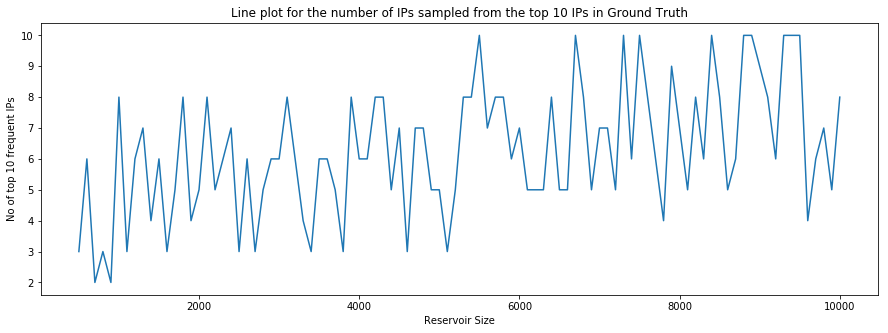

In [22]:
def reservoirSampling(df, topk=10, col='Destination'):
    
    data_ips = df[col]
    print (' -- Ground Truth : Top IPs -- ')
    ip_globaltopK, ip_globaltopK_count = getTopIPs(df_scene02, topk, verbose=1)
    print ('')
    plot_vals = []
    # reservoir size begins at 100 and goes upto 20000 increasing in size by 100 in each iteration
    reservoirs = range(500, 20100, 100)
    for k in reservoirs:
        reservoir = []
        n = 0
        
        
        if (1):
            start = time.time()
            for ip_tmp in data_ips:
                n += 1
                if len(reservoir) < k:
                    reservoir.append(ip_tmp)
                else:
                    s = random.randint(0, n)
                    if s < k:
                        reservoir[s] = ip_tmp
            end = time.time()
            print('Time', end - start)
        
        if (1):
            ip_counter = Counter(reservoir).most_common(topk)
            count = 0
                       
            for obj_id, ip_obj in enumerate(ip_counter):
                if ip_obj[0] == ip_globaltopK[obj_id]:
                    count +=1
                    print(count, ') IP: ',ip_obj[0] ,' || Netflows:', ip_obj[1],'  Percentage:', round(ip_obj[1]*100.0/k,3), '%')
            plot_vals.append(count)
            print('Reservoir size: ', k)
            print('No of IPs sample from the ground truth: ', count)
            print('_______________________________________')
    
    f,axarr = plt.subplots(1, figsize=(15,5))
    plt.xlabel('Reservoir Size')
    plt.ylabel('No of top 10 frequent IPs')
    plt.title('Line plot for the number of IPs sampled from the top 10 IPs in Ground Truth')
    plt.plot(reservoirs, plot_vals)

if __name__ == "__main__":    
    random.seed(42)
    reservoirSampling(df_scene02)